In [1]:
#Define dependencies.
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import scipy
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
#Import datasets.
restaurant_train = pd.read_csv('train.csv')
restaurant_test = pd.read_csv('test.csv')

In [3]:
#Let's see what columns we have available, and if they coincide with those provided on kaggle.
restaurant_train.columns.values

array(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3',
       'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22',
       'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue'], dtype=object)

In [4]:
#head view of dataset
restaurant_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [5]:
#Filter dataset to city and revenue columns.
rev_city = restaurant_train[['City','revenue']]

In [6]:
#Generate a list of unique cities to be used for the revenue filter.
city = rev_city['City'].drop_duplicates().sort_values().tolist()

In [7]:
#Group revenues by city.
tcity = rev_city.groupby('City')

In [8]:
#Generate list of revenues for each unique city.
rev_city = [sum(tcity.get_group(i)['revenue']) for i in city]

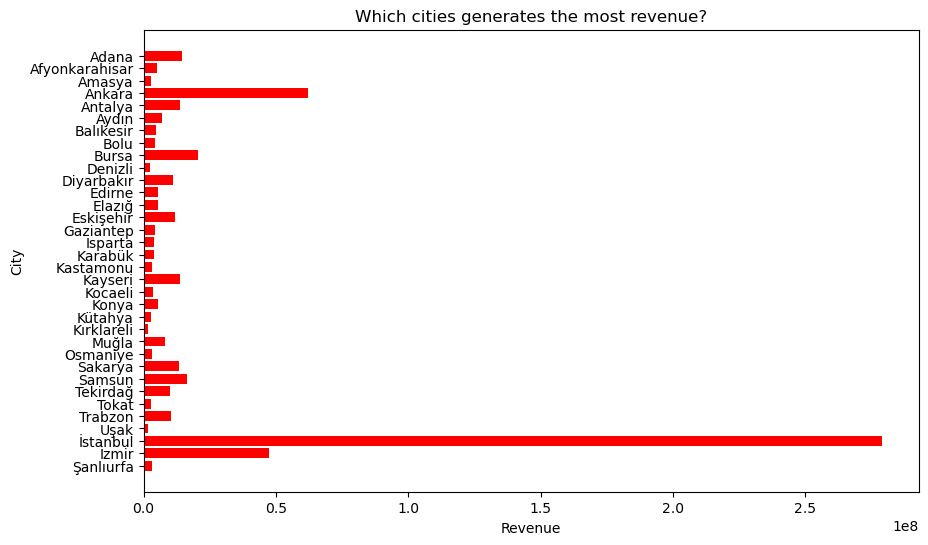

In [9]:
#Generate horizontal bar plot to see which city generates the most revenue.
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,6))
y_pos = np.arange(len(city))

ax.barh(y_pos,rev_city, color ='r')
ax.set_ylabel('City')
ax.set_yticks(y_pos)
ax.set_yticklabels(city)
ax.invert_yaxis()
ax.set_xlabel('Revenue')
ax.set_title('Which cities generates the most revenue?')

plt.show()

In [10]:
#Store the necessary columns for this part.
rev_type = restaurant_train[['Type','revenue']]

In [11]:
#Consolidate the 'Type' features.
rtype = rev_type['Type'].drop_duplicates().tolist()

In [12]:
#Group the values by 'Type'
ttype = rev_type.groupby('Type')

In [13]:
#Sum and store the revenues by 'Type'
rev_type = [sum(ttype.get_group(i)['revenue']) for i in rtype]

In [14]:
#Store the complete 'Type' names.
rtype = ['Inline', 'Food Court', 'Drive Thru']

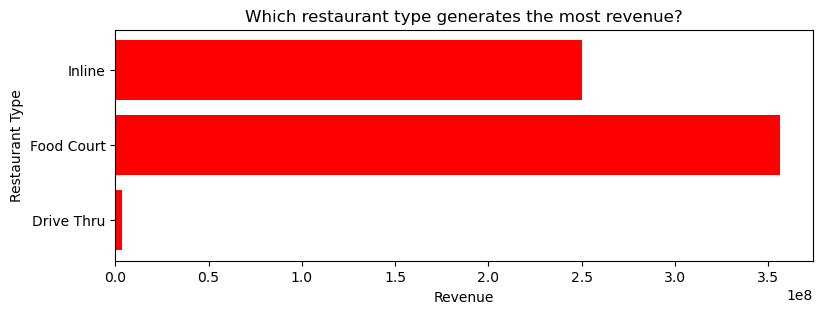

In [15]:
#Generate horizontal bar plot to see which restaurant type generates the most revenue.
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(9,3))
y_pos = np.arange(len(rtype))

ax.barh(y_pos,rev_type,color='r')
ax.set_ylabel('Restaurant Type')
ax.set_yticks(y_pos)
ax.set_yticklabels(rtype)
ax.invert_yaxis()
ax.set_xlabel('Revenue')
ax.set_title('Which restaurant type generates the most revenue?')

plt.show()

In [16]:
#Concatenate both datasets.
tot = restaurant_train

In [17]:
#Store months and years in lists.
month = [i.split('/')[0] + '/' for i in tot['Open Date']]
year = [i.split('/')[2] for i in tot['Open Date']]

In [18]:
#Generate a new dataframe for this part of the exploration.
odate = pd.DataFrame([x+y for x,y in zip(month,year)], columns = ['date']).sort_values(by=['date'])
odate = odate.reset_index(drop=True)

In [19]:
#Transform 'date' column to datetime format in order to accurately sort the dates, 
#then send it back as a string.
odate['date'] = pd.to_datetime(odate['date'])
odate = odate.sort_values(by='date').reset_index(drop=True)
odate['date'] = [str(i)[:7] for i in odate['date']]

In [20]:
#Store the counts for each date considered, preparing it for a bar plot.
date_count = [i for i in odate['date'].value_counts().sort_index()]

In [21]:
#Minimize dataset to one entry per date to match the corresponding counts previously calculated.
odate = odate.drop_duplicates().reset_index(drop=True)

In [22]:
#Import the counts into the date subset dataset.
odate['date_count'] = date_count

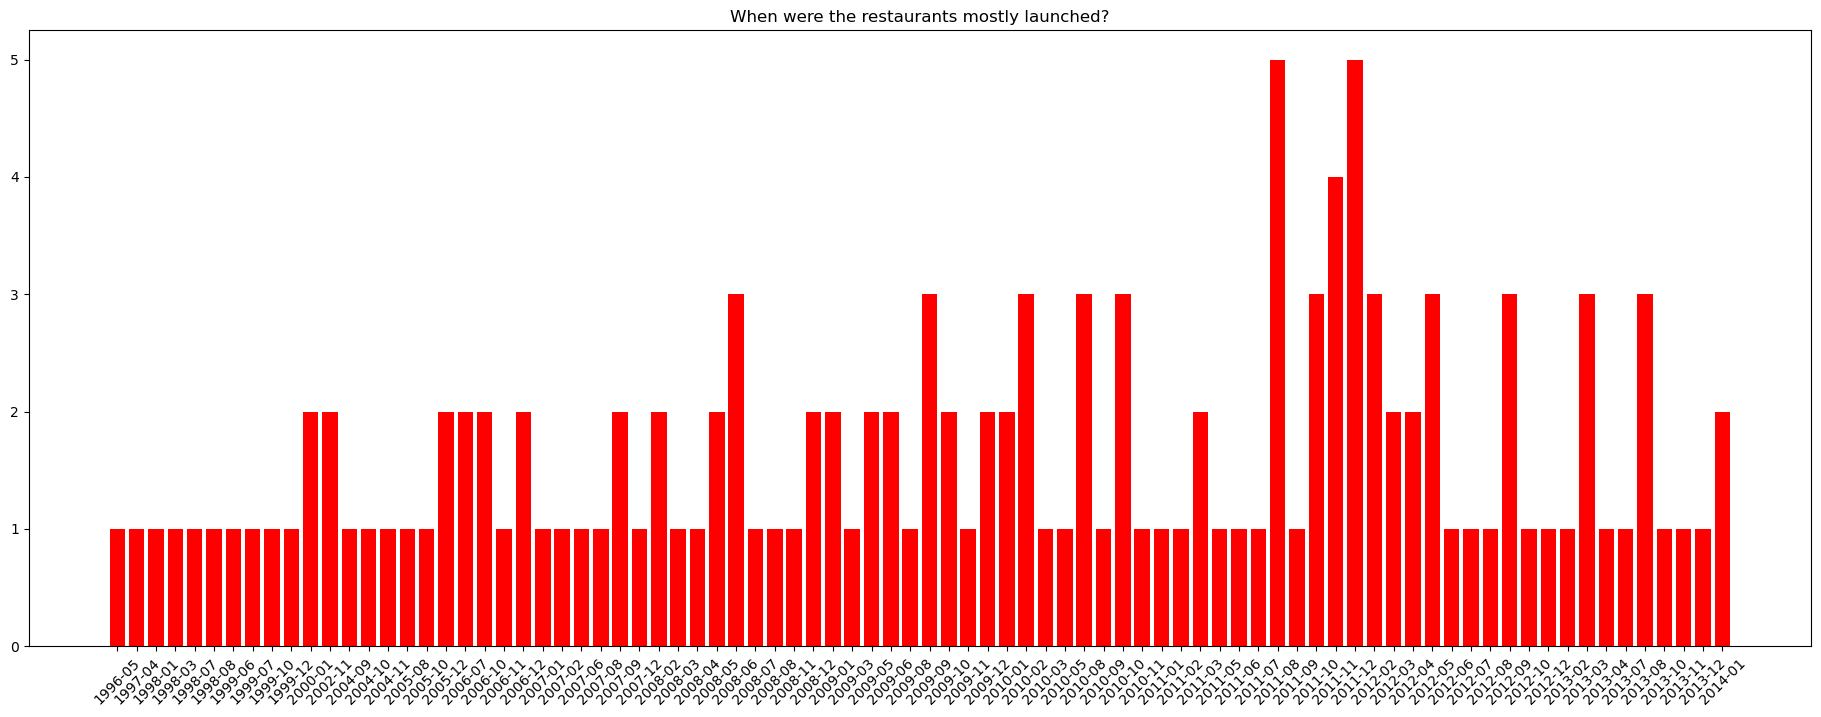

In [23]:
#Display the trend in a barplot.
plt.figure(figsize=(23,8))
plt.bar(odate['date'],odate['date_count'],color='r')
plt.title('When were the restaurants mostly launched?')
plt.xticks(rotation='45')
plt.show()

#### Check if data revenue is normalized

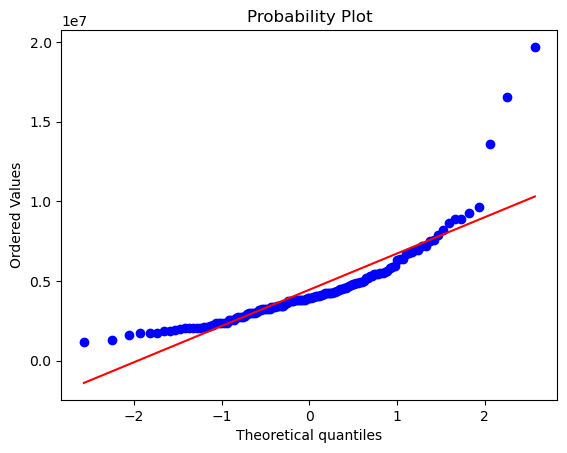

In [24]:
scipy.stats.probplot(restaurant_train['revenue'], dist = 'norm', plot=plt)
plt.show()

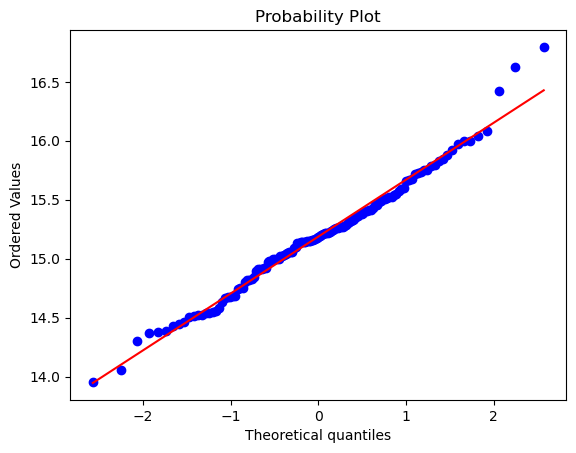

In [25]:
scipy.stats.probplot(np.log(restaurant_train['revenue']), dist='norm', plot=plt)
plt.show()

#### Data Preparation before using linear regression for training

In [26]:
#First column that needs to be transformed from a categorical variable to a numerical one.
restaurant_train['City Group'].drop_duplicates()

0    Big Cities
2         Other
Name: City Group, dtype: object

In [27]:
#Replace the column values with 0 if it is a 'Big City' data point, otherwise place a 1, 
#and store these values into the same column.
restaurant_train['City Group'] = [1 if i == 'Other' else 0 for i in restaurant_train['City Group'].tolist()]

In [28]:
#Set the dummy variables for the 'type' column.
restaurant_train['Type'] = [int(3) if k == 'DT' else k for k in [int(2) if j == 'IL' else j for j in [int(1) if i == 'FC' else i for i in restaurant_train['Type']]]]

In [29]:

#One last thing to consider is the date, 
#and since this is a string, I will cut it down to just the year and transform it to an int.
restaurant_train[['month','day','year']] = restaurant_train['Open Date'].str.split('/',expand=True)
restaurant_train['year'] = [int(i) for i in restaurant_train['year']]
restaurant_train['month'] = [int(i) for i in restaurant_train['month']]
restaurant_train['day'] = [int(i) for i in restaurant_train['day']]


In [30]:
#Dataset is ready for PCA section and beyond.
restaurant_train = restaurant_train.iloc[:,3:]
restaurant_train.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P32,P33,P34,P35,P36,P37,revenue,month,day,year
0,0,2,4,5.0,4.0,4.0,2,2,5,4,...,4,5,5,4,3,4,5653753.0,7,17,1999
1,0,1,4,5.0,4.0,4.0,1,2,5,5,...,0,0,0,0,0,0,6923131.0,2,14,2008
2,1,2,2,4.0,2.0,5.0,2,3,5,5,...,0,0,0,0,0,0,2055379.0,3,9,2013
3,1,2,6,4.5,6.0,6.0,4,4,10,8,...,10,6,18,12,12,6,2675511.0,2,2,2012
4,1,2,3,4.0,3.0,4.0,2,2,5,5,...,3,2,3,4,3,3,4316715.0,5,9,2009


In [31]:
#Let's make a copy of the test set.
res_test = restaurant_test.copy()

In [32]:
#Now let's start forming our dataset to match that of the training set, 
#with the exception of the revenue column for the analysis.
res_test[['month','day','year']] = res_test['Open Date'].str.split('/',expand=True)
res_test['year'] = [int(i) for i in res_test['year']]
res_test['month'] = [int(i) for i in res_test['month']]
res_test['day'] = [int(i) for i in res_test['day']]

In [33]:
#Replicate dummy variable for the city group variable.
res_test['City Group'] = [1 if i == 'Other' else 0 for i in res_test['City Group']]

In [34]:
#Replicate the dummy variable process for the 'type' column.
res_test['Type'] = [int(3) if k == 'DT' else k for k in [int(2) if j == 'IL' else j for j in [int(1) if i == 'FC' else i for i in res_test['Type']]]]

In [35]:
#Since this dataset is the one that contains the mobile option (MB), 
#then I will be setting this as null in order to find and compensate for it in the next steps.
res_type = [np.nan if i == 'MB' else i for i in res_test['Type']]

In [36]:
#Substitute back in for the 'type' column in the main dataframe.
res_test['Type'] = res_type

In [37]:
#Let's see what it looks like!
knni_test = res_test.iloc[:,3:]
knni_test.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,month,day,year
0,1,1.0,1,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,0,0,0,1,22,2011
1,1,2.0,3,4.0,4.0,4.0,2,2,5,3,...,0,0,0,0,0,0,0,3,18,2011
2,0,1.0,3,4.0,4.0,4.0,2,2,5,4,...,0,0,0,0,0,0,0,10,30,2013
3,1,2.0,2,4.0,4.0,4.0,2,3,5,4,...,4,0,0,0,0,0,0,5,6,2013
4,1,1.0,2,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,0,0,0,7,31,2013


In [38]:
#Define the KNNImputer function.
imputer = KNNImputer()

In [39]:
#Send data to the KNNImputer
imputer.fit(knni_test)

KNNImputer()

In [40]:
#Store the transformed data once sent to the KNNImputer
knni_sol = imputer.transform(knni_test)

In [41]:
#Format the resultant dataframe from the data received.
knni_test = pd.DataFrame(knni_sol, columns = [i for i in knni_test.columns.values])

In [42]:
#Now that the dataframe is updated to compensate for the mobile (MB) option of the 'type' column,
#let's quickly see what values are available and if they coincide with those available on the training dataset.
knni_test['Type'].drop_duplicates()

0        1.0
1        2.0
35       3.0
543      1.2
1001     1.4
1444     1.8
4117     1.6
45034    2.4
Name: Type, dtype: float64

In [43]:
#Given that the values available are floats with decimal values in between the values allowed,
#this will be fixed by setting boundaries that will output corresponding dummy variables to those in the training set.
knni_test['Type'] = [2.0 if (j >= 1.5 and j < 2.5) else j for j in [1 if (i > 1 and i < 1.5) else i for i in knni_test['Type']]]

In [44]:
knni_test.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,month,day,year
0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,2011.0
1,1.0,2.0,3.0,4.0,4.0,4.0,2.0,2.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,2011.0
2,0.0,1.0,3.0,4.0,4.0,4.0,2.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,30.0,2013.0
3,1.0,2.0,2.0,4.0,4.0,4.0,2.0,3.0,5.0,4.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6.0,2013.0
4,1.0,1.0,2.0,4.0,4.0,4.0,1.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,31.0,2013.0


In [45]:
res_train = pd.read_csv('train.csv')

In [46]:
len(res_train['City'].drop_duplicates())

34

In [47]:
len(res_test['City'].drop_duplicates())

57

In [48]:
rtrain_y = restaurant_train['revenue'].copy()
rtrain_y

0      5653753.0
1      6923131.0
2      2055379.0
3      2675511.0
4      4316715.0
         ...    
132    5787594.0
133    9262754.0
134    2544857.0
135    7217634.0
136    6363241.0
Name: revenue, Length: 137, dtype: float64

In [49]:
#Take the logarithm of the 'revenue' column to generate better results.
restaurant_train['revenue'] = np.log(restaurant_train['revenue'])

In [50]:
#Store the response variable for the training set.
rtrain_ylog = restaurant_train['revenue']
rtrain_ylog

0      15.547830
1      15.750379
2      14.535971
3      14.799651
4      15.278005
         ...    
132    15.571227
133    16.041512
134    14.749585
135    15.792038
136    15.666048
Name: revenue, Length: 137, dtype: float64

In [51]:
#Update the feature dataset.
restaurant_train.drop(columns=['revenue'], inplace=True)

In [52]:
#Generate a StandardScaler instance.
scaler = StandardScaler()
rtrain_x = scaler.fit_transform(restaurant_train)
rtrain_x = pd.DataFrame(rtrain_x, columns = [i for i in restaurant_train.columns.values])
rtrain_x.head()

rtest_x = scaler.fit_transform(knni_test)
rtest_x = pd.DataFrame(rtest_x, columns = [i for i in knni_test.columns.values])
rtest_x.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,month,day,year
0,0.985544,-0.832175,-1.097791,-0.299599,-0.255683,-0.382329,-0.928924,-0.575870,-0.137939,-0.541757,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,-1.763432,0.830477,0.583631
1,0.985544,1.017144,-0.386793,-0.299599,-0.255683,-0.382329,0.009772,-0.575870,-0.137939,-1.123666,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,-1.171141,0.386318,0.583631
2,-1.014668,-0.832175,-0.386793,-0.299599,-0.255683,-0.382329,0.009772,-0.575870,-0.137939,-0.541757,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,0.901879,1.718796,1.002011
3,0.985544,1.017144,-0.742292,-0.299599,-0.255683,-0.382329,0.009772,0.077118,-0.137939,-0.541757,...,1.216097,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,-0.578849,-0.946161,1.002011
4,0.985544,-0.832175,-0.742292,-0.299599,-0.255683,-0.382329,-0.928924,-0.575870,-0.137939,-0.541757,...,-0.517056,-0.489172,-0.643361,-0.450052,-0.567659,-0.517346,-0.580411,0.013442,1.829836,1.002011


#### Analysis
#### Principal Component Analysis
Once we have the data normalized, we can perform the PCA to reduce the amount of dimensions available. Using the sci-kit learn library from python, the steps of this process go as follows:

In [53]:
#Instantiate the Principal Component Analysis (PCA) with 10 features as our target.
pca_train = PCA(n_components = 10)
pca_test = PCA(n_components = 10)

#Fit the feature data to the PCA.
pca_train.fit(rtrain_x)
pca_test.fit(rtest_x)

#Let's see how they are weighted.
print(pca_train.explained_variance_ratio_)
print(pca_test.explained_variance_ratio_)
             

[0.49316116 0.15932306 0.06181891 0.038904   0.0328049  0.02712942
 0.02520381 0.01879001 0.01673834 0.01397938]
[0.25444565 0.11678621 0.04459055 0.0320989  0.02573614 0.0239156
 0.0235685  0.02176295 0.02082484 0.01919757]


In [54]:
#Fully transform the feature data to the PCA features.
pca_train_rcomp = pca_train.transform(rtrain_x)
pca_test_rcomp = pca_test.transform(rtest_x)

#Generate and display the dataframe with the main PCA components generated.
pca_train = pd.DataFrame(data=pca_train_rcomp, columns = ['PCA '+str(i) for i in range(10)])
pca_train.head()

#Generate and display the dataframe with the main PCA components generated.
pca_test = pd.DataFrame(data=pca_test_rcomp, columns = ['PCA '+str(i) for i in range(10)])
pca_test.head()

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9
0,-2.535814,0.111860,0.365628,-1.849531,-0.946157,-1.295376,0.358773,1.437873,0.193329,0.224186
1,-2.648913,-0.140508,0.090411,-1.172294,-0.548686,-0.571507,-0.033065,0.705500,-0.744239,-0.520268
2,-2.057663,0.855578,1.706542,-0.849274,2.119868,-0.236946,0.866312,-0.145567,0.400694,-0.363801
3,-1.873068,-0.176874,-0.281537,-0.723174,-1.046724,-0.074009,-0.377777,-0.430170,-0.799385,0.212395
4,-2.757643,0.275739,0.333217,-1.157498,1.193756,-1.040428,0.082578,1.198752,0.021999,0.714760


#### Linear Regression

Arriving at the final portion of the analysis, the revenue will be predicted using a linear regression method. Considering the different combinations available for both the response variables and the features available(x), the results in the end speak for themselves and hint at the non-normalized and non-PCA method to be the best performing 𝑅^2

In [55]:
## Choice 1: PCA training set and log applied response variable.

In [56]:
lr_model = linear_model.LinearRegression()
lr_model.fit(pca_train,rtrain_ylog)
y_pred = lr_model.predict(pca_test)

print(y_pred)
print(lr_model.score(pca_train,rtrain_ylog))

[15.40848009 15.27348028 15.33518353 ... 15.32401479 15.10428984
 15.02648539]
0.16432385226944068


In [57]:
lr_mod1 = linear_model.LinearRegression()
print(pca_train)
lr_mod1.fit(pca_train, rtrain_y)
y_pred1 = lr_mod1.predict(pca_test)

print(y_pred1)
print(lr_mod1.score(pca_train, rtrain_y))

         PCA 0     PCA 1     PCA 2     PCA 3     PCA 4     PCA 5     PCA 6  \
0     1.012842 -2.438753  0.676485 -0.478576  0.245135 -0.125838 -0.493670   
1    -2.569325  0.616360  0.569430 -1.591578 -0.200607 -0.204548  1.100668   
2    -2.982403  0.001187 -1.559098  0.356310  0.955777 -0.998175  0.736698   
3    10.754897  0.797182 -3.881189  3.059873  0.144958 -1.669889  1.866375   
4     0.043206 -2.614608 -1.376587  0.011273 -0.089899 -0.456133  0.391977   
..         ...       ...       ...       ...       ...       ...       ...   
132  -3.260501  0.263221 -0.581766  1.684246  1.856965 -0.571290 -0.437081   
133  -2.475435  0.769704  0.770533 -0.110931  0.280632 -0.754089 -1.308783   
134  -2.723904  0.619155 -0.622556 -0.313306 -0.917143 -0.673941 -0.386899   
135  -2.619216  0.810216 -0.393201 -0.810296  1.285564  1.172631 -0.953334   
136  -2.739747  0.649834  0.355574 -0.065740  0.422461 -1.346394 -1.175797   

        PCA 7     PCA 8     PCA 9  
0    2.554560 -0.299681  1.

In [58]:
## Choice 3: Regular training set and normal response variable.

In [59]:
lr_mod2 = linear_model.LinearRegression()
lr_mod2.fit(restaurant_train, rtrain_y)
y_pred2 = lr_mod2.predict(knni_test)

print(y_pred2.shape)
print(lr_mod2.score(restaurant_train, rtrain_y))

(100000,)
0.3569846055345667


In [60]:
#Display predicted values for the 100000 rows in the test set.
[i for i in y_pred2]

[5069925.4761353135,
 2585634.5501245856,
 2205658.004566431,
 5105022.065558493,
 6035626.485367358,
 11509475.29300797,
 6002148.023815513,
 4825013.863274038,
 7925251.596650481,
 -4553730.128815472,
 13997791.74826628,
 6584909.234018385,
 1186518.104397118,
 8361326.036530197,
 10562568.118295431,
 6589065.419166565,
 6873178.821852863,
 -1149533.3277103305,
 8806825.31891483,
 8427440.304680288,
 7166868.476918519,
 -281058.87235963345,
 1679170.271386087,
 2717029.3246386647,
 9105694.967150152,
 7741527.891560614,
 2389246.190880835,
 7370505.3218333125,
 3420512.986309409,
 4737909.86242193,
 13025442.472776711,
 5695185.307169914,
 2083711.41964823,
 5121758.712117493,
 -138936.33300608397,
 7541933.255994141,
 3581989.0248194337,
 21865375.249154627,
 2143299.9765052795,
 -2438456.5614979267,
 8906322.799616754,
 2999220.906890869,
 27675012.184821784,
 7834132.125798643,
 1846802.5350068808,
 3709732.875111103,
 8163026.891154349,
 -6610030.684291601,
 -7057350.107393384,
 

In [61]:
def normalize(X):
    mean = np.mean(X,axis =0)
    std = np.std(X,axis =0)
    X_new = (X-mean)/std
    return X_new, mean, std

In [62]:
def prepare_X(X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.array(X[:])
    X_new = np.column_stack((ones, X_new))
    return X_new

In [63]:
def hypothesis(X, theta):
    h_thetha = X.dot(theta);
    return h_thetha

In [64]:
def cost_function(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    J = sum((hypothesis(X,theta) - y)**2)/(2*m)
    return J

In [65]:
def derivative(X, y, theta):
    m = X.shape[0]
    d_thetha =np.array(((hypothesis(X,theta)-y).dot(X))/m)
    return d_thetha

In [66]:
def gradient_descent(X, y, theta, alpha, max_num_iters,eps, print_J = True):
    m = X.shape[0]
    J_history = []
    J = cost_function(X, y, theta)
    current_iteration = 0;
    if print_J == True:
        print(J)
    J_history.append(J)
    while(True):
        delta =derivative(X, y, theta)*alpha;
        theta = theta - delta;
        J = cost_function(X, y, theta);
        if print_J == True:
            print(J);
        J_history.append(J)
        current_iteration+=1;
        if(abs(J_history[-1] - J_history[-2]) < eps or current_iteration >max_num_iters): 
            break;
    return theta, J_history

In [67]:
def Predict(X,mean,std,theta):
    X =(X-mean)/std;
    X = prepare_X(X)
    predicted =hypothesis(X,theta);
    return predicted

In [68]:
X_train_norm, mean, std = normalize(restaurant_train)
X_train = prepare_X(X_train_norm)
print(X_train)
theta = np.array([0 for i in range (43)])
print(theta)

[[ 1.         -0.86971849  1.06881426 ... -0.01632198  0.26258978
  -2.41208951]
 [ 1.         -0.86971849 -0.88355313 ... -1.41389122 -0.07573122
  -0.1691737 ]
 [ 1.          1.14979733  1.06881426 ... -1.13437737 -0.63959955
   1.07689064]
 ...
 [ 1.          1.14979733 -0.88355313 ... -0.01632198 -0.75237321
  -0.66759943]
 [ 1.         -0.86971849 -0.88355313 ...  0.82221957  1.61587376
   0.32925204]
 [ 1.         -0.86971849 -0.88355313 ...  0.54270572 -1.54178887
   0.08003917]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [69]:
print(f'X:{X_train.shape}')
print(f'y:{rtrain_y.shape}')
print(theta)
print(cost_function(X_train, rtrain_y, theta))

X:(137, 43)
y:(137,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
13210829294441.21


In [70]:
alpha = 0.005
max_num_iters = 10000
eps = 1e-16

In [71]:
print(X_train.shape)
print(rtrain_y.shape)
new_theta, Js = gradient_descent(X_train, rtrain_y, theta, alpha, max_num_iters,eps, False)
print(new_theta)

(137, 43)
(137,)
[ 4453532.6131386   -216143.36997349  -470461.66482339   347138.43100545
   330933.43870814  -166611.82454759    48742.82253132   -52167.04571422
   498714.6511004     61696.10502065 -1747414.64949502  1252605.61507491
   -29696.73241543  -364932.0573731    346047.00019632  -614475.87456157
  -528386.29618343  -367680.06589542   -13179.15775986   627769.39722413
   823261.28508246  -257250.64517925  -952292.46715859   405074.59283734
  -368860.67006653   491372.75114417   211854.26350587   607540.07569225
 -1469403.46195563   179383.27046486   940537.75753717   -96861.99158188
   170351.6414657    279422.58056362  -848977.68330131  -115617.13661639
  -393816.15777504   284053.00450878   424124.49635738   128242.74707378
    -8872.52755081   207506.97713228  -699010.03425791]


In [72]:
predicted = Predict(knni_test,mean,std,new_theta)
[i for i in predicted]

[4884155.686212611,
 2842013.617811409,
 3282999.8636357146,
 4014172.251940466,
 6074288.002902497,
 7282292.694176347,
 4719808.65390414,
 4937998.676858576,
 7703822.354744944,
 -266101.7776927217,
 10562025.046713755,
 5856394.20601942,
 2813893.994868178,
 5650491.668763123,
 7633430.4844368035,
 6648094.630642017,
 8039722.20734666,
 -230027.97326938502,
 9711129.58196085,
 6453194.358036363,
 4630932.693327172,
 2072329.5167641512,
 2445093.5089744306,
 3583115.912713997,
 9695963.171035828,
 7126707.4899638705,
 2270372.635927787,
 5660090.186204299,
 3834006.587596553,
 5885356.960685828,
 9990302.601928432,
 1403433.746067522,
 2567290.5047131116,
 5675314.667117548,
 2259050.2107697465,
 6197647.118493744,
 3995488.9450780097,
 11921725.578404564,
 3048694.3332248223,
 -955664.6903680065,
 6684090.633970669,
 3847149.5781405484,
 11962324.679590395,
 6498823.013761331,
 4208345.998859877,
 4074743.5452520666,
 5914795.728909906,
 -4091317.258575948,
 -2388420.95665462,
 4599

In [73]:
print(f"average_absolute_error:{mean_absolute_error(y_pred2,predicted)}")
print(f"average_squared_error:{mean_squared_error(y_pred2,predicted)}")
print(f"root_mean_squared_error:{mean_squared_error(y_pred2,predicted,squared=False)}")

average_absolute_error:1524907.249126184
average_squared_error:6107390960674.558
root_mean_squared_error:2471313.6103446195
